In [1]:
import pandas as pd
from skimpy import skim
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from neuralforecast import NeuralForecast
from mlforecast import MLForecast
from statsforecast.models import Naive, SeasonalNaive, SimpleExponentialSmoothing, RandomWalkWithDrift
from statsforecast import StatsForecast
from neuralforecast.models import LSTM, GRU, NBEATS, TFT, MLP
from neuralforecast.losses.pytorch import MAE, MSE
import time

# --------------------------------------------------------------
# Day 18: Final Model 🤖
# --------------------------------------------------------------

In [2]:
def plot_ts(df):
    code = df['postcode'].values[0]
    property_type = df['propertyType'].values[0]
    plt.plot(df['full_date'], df['price/bedroom'])
    plt.title(f'Price/Bedroom vs. Date Sold for Post Code {code} and Housing Type {property_type}')
    plt.xlabel('Date Sold')
    plt.ylabel('Price/Bedroom')

In [35]:
def predict_and_visualize_forecast(model, ts, year):
    model_str = list(model.models.keys())[0]
    final_year = 
    preds = model.predict(horizon)[model_str]['predictions']
    code = ts['postcode'].values[0]
    prop = ts['propertyType'].values[0]
    plt.plot(range(ts['full_date'].shape[0]), ts['price/bedroom'])
    plt.plot(range(ts['full_date'].shape[0], ts['full_date'].shape[0] + horizon), preds)
    plt.xlabel('index')
    plt.ylabel('price/bedroom')
    plt.title(f'Forecast for Price/Bedroom for Postcode {code} and Housing Type {prop}')
    plt.legend(['history', 'forecast'])
    plt.show()

In [5]:
def prepare_and_clean_frames(master_df, post_code, housing_type):

    master_df['datesold'] = master_df['datesold'].apply(lambda x: pd.to_datetime(x))

    master_df['datesold_year'] = master_df['datesold'].apply(lambda x: x.year)
    master_df['datesold_month'] = master_df['datesold'].apply(lambda x: x.month)
    master_df['datesold_day'] = master_df['datesold'].apply(lambda x: x.day)
    
    unit_code = master_df[(master_df['postcode'] == post_code) & (master_df['propertyType'] == housing_type)].sort_values('datesold')

    unit_code_final = unit_code.groupby(['datesold_year', 'datesold_month']).agg({
    'postcode':pd.Series.mode, 'price':'sum', 'propertyType':pd.Series.mode, 'bedrooms':'sum', 
    }).reset_index()

    unit_code_final['full_date'] = pd.to_datetime(
        unit_code_final['datesold_year'].astype(str) + '-' + unit_code_final['datesold_month'].astype(str) + '-01'
        )
    unit_code_final['price/bedroom'] = unit_code_final['price']/unit_code_final['bedrooms']

    unit_code_final = unit_code_final.drop(['datesold_year', 'datesold_month','price', 'bedrooms'], axis=1)

    date_range = pd.date_range(start=unit_code_final['full_date'].min(), end=unit_code_final['full_date'].max(), freq='MS')
    missing_dates = date_range.difference(unit_code_final['full_date'])

    missing_df = pd.DataFrame({
        'postcode':post_code,
        'propertyType':housing_type,
        'full_date': missing_dates,
        'price/bedroom':np.nan
    })

    full_data = pd.concat([missing_df,unit_code_final]).sort_values('full_date')

    full_data['price/bedroom'] = full_data['price/bedroom'].ffill()
    
    if np.inf in full_data['price/bedroom'].values:
        with_inf = full_data[full_data['price/bedroom'] == np.inf]
        without_inf = full_data[full_data['price/bedroom'] != np.inf]
        with_inf['price/bedroom'] = np.mean(without_inf['price/bedroom'])
        full_data = pd.concat([with_inf, without_inf])

    return full_data


In [6]:
def run_BaselineForecast(df):

    X_train, X_test, y_train, y_test = train_test_split(df['full_date'], df['price/bedroom'], test_size=.25, shuffle=False)
    y_preds_test = np.tile(y_train.values[-1:], X_test.shape[0])
    error = mean_absolute_error(y_preds_test, y_test)
    model = 'Naive'
    
    kwargs = {
        'model':model,
        'error':error,
        'X_train':X_train,
        'X_test':X_test,
        'y_train':y_train,
        'y_test':y_test,
        'y_test_preds':y_preds_test,
        'df':df
    }

    return kwargs



In [12]:
def run_NeuralForecast(df, months):
    X_train, X_test, y_train, y_test = train_test_split(df['full_date'], df['price/bedroom'], test_size=.25, shuffle=False)

    df_train_NIXTLA = pd.DataFrame({
        'unique_id':0,
        'ds': X_train,
        'y': y_train
    })

    df_test_NIXTLA = pd.DataFrame({
        'unique_id':0,
        'ds':X_test,
        'y':y_test
    })

    models = [MLP(
        h=df_test_NIXTLA.shape[0],
        input_size=12,
        max_steps=100,
        random_seed=22,
        loss=MAE(),
    )]

    model = NeuralForecast(models=models, freq='MS')
    model.fit(df_train_NIXTLA)
    preds_test = model.predict()

    error = mean_absolute_error(df_test_NIXTLA['y'].values, preds_test['MLP'])

    models = [MLP(
        h=months,
        input_size=12,
        max_steps=100,
        random_seed=22,
        loss=MAE(),
    )]

    model = NeuralForecast(models=models, freq='MS')
    model.fit(pd.concat([df_train_NIXTLA, df_test_NIXTLA]))
    y_preds = model.predict()

    kwargs = {
        'model':model,
        'error':error,
        'df_train':df_train_NIXTLA,
        'df_test':df_test_NIXTLA,
        'y_test_preds':preds_test,
        'df':df,
        'predictions':y_preds
    }
    
    return kwargs

In [81]:
def predict_and_visualize_forecast(ts, year, bedrooms):
    year = 2020
    date1 = pd.to_datetime(ts['full_date'].values[-1:][0])
    date2 = pd.to_datetime(f'{year+1}-12-1') 

    difference = relativedelta(date2, date1)
    months_difference = difference.years * 12 + difference.months
    model_str = 'Neural Forecast'
    horizon = months_difference
    preds = run_NeuralForecast(ts, horizon)['predictions']
    code = ts['postcode'].values[0]
    prop = ts['propertyType'].values[0]

    best_price = min(preds[preds['ds'].apply(lambda x: x.year == year)]['MLP'])
    best_date = pd.to_datetime(preds[preds['MLP'] == best_price]['ds'].values[0])
    total_price = best_price*bedrooms

    print(f'Best month to buy: {best_date.month}/{best_date.day}/{best_date.year}')
    print(f'Price per bedroom: ${np.round(best_price, 2)}')
    print(f'Total cost for {bedrooms} bedrooms: ${np.round(total_price,2)}')
    print(best_date)

    plt.plot(ts['full_date'], ts['price/bedroom'])
    plt.plot(preds['ds'], preds['MLP'])
    plt.xlabel('date')
    plt.ylabel('price/bedroom')
    plt.title(f'Forecast for Price/Bedroom for Postcode {code} and Housing Type {prop}')
    plt.legend(['history', 'forecast'])
    plt.show()

Seed set to 22
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | mlp          | ModuleList    | 1.1 M  | train
4 | out          | Linear        | 39.0 K | train
-------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.407     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
Seed set to 22
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | mlp          | ModuleList    | 1.1 M  | train
4 | out          | Linear        | 29.7 K | train
-------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.371     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


Best month to buy: 5-1-2020
Price per bedroom: $228599.11
Total cost for 3 bedrooms: $685797.33
2020-05-01 00:00:00


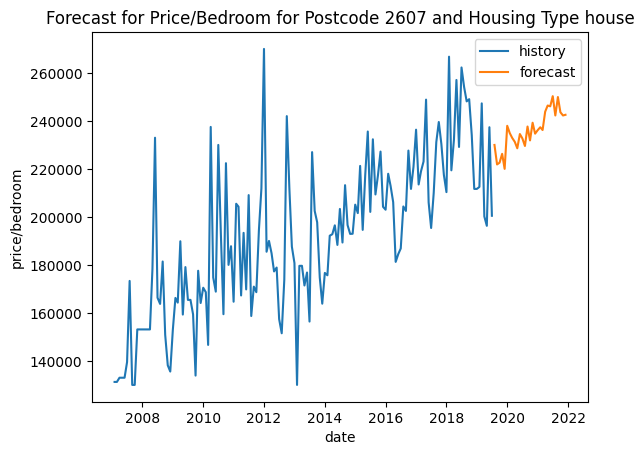

In [82]:
predict_and_visualize_forecast(x, 2020, 3)

In [60]:
preds

,ds,MLP
unique_id,,
0,2016-06-01,211866.609375
0,2016-07-01,216960.656250
0,2016-08-01,212068.406250
0,2016-09-01,219235.359375
0,2016-10-01,212744.578125
0,2016-11-01,225637.750000
0,2016-12-01,213727.453125
0,2017-01-01,217415.625000
0,2017-02-01,216306.281250


In [54]:
preds[preds['ds'].apply(lambda x: x.year == year)]

,ds,MLP
unique_id,,


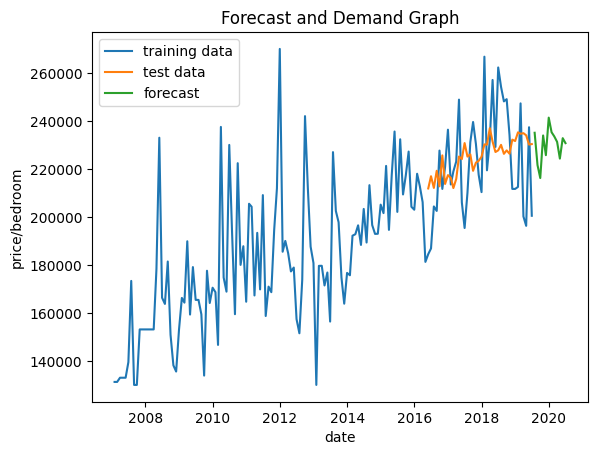

In [54]:
plt.plot(df['full_date'], df['price/bedroom'])
plt.plot(preds_test['ds'], preds_test['MLP'])
plt.plot(preds_future['ds'], preds_future['MLP'])
plt.title('Forecast and Demand Graph')
plt.xlabel('date')
plt.ylabel('price/bedroom')
plt.legend(['training data', 'test data', 'forecast'])

In [ ]:
df = pd.read_csv('raw_sales.csv')
all_postcodes = df['postcode'].unique()
housing_type_1 = 'unit'
housing_type_2 = 'house'

ts_sets = {}

for code in all_postcodes:
    try:
        code_house = prepare_and_clean_frames(df, code, 'house')
        code_unit = prepare_and_clean_frames(df, code, 'unit')
        ts_sets[code] = [code_house, code_unit]
    except:
        ts_sets[code] = 'NOT ENOUGH DATA'

In [ ]:
models_and_postcodes = {}
for postcode in all_postcodes:
    if ts_sets[postcode] != 'NOT ENOUGH DATA':
        models = []
        house_unit = [ts_sets[postcode][0], ts_sets[postcode][1]]
        for type in house_unit:
            naive = run_BaselineForecast(type)
            ml = run_NeuralForecast(type,months=18)
            if naive['error'] < ml['error']:
                models.append(naive['model'])
            else:
                models.append(ml['model'])
        models_and_postcodes[postcode] = models

In [16]:
winner_count = 0
for key in models_and_postcodes.keys():
    for cast in models_and_postcodes[key]:
        if cast != 'Naive':
            winner_count+=1

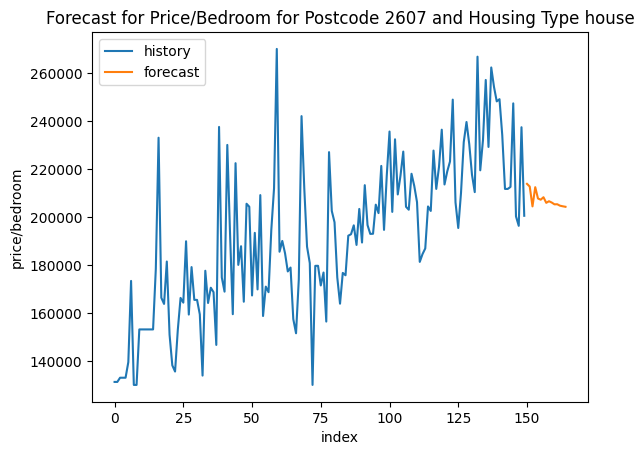

In [228]:
user_post = int(input('Enter a postcode (press q to quit): '))
user_type = input('Enter a housing type (unit or house): ')
user_hrzn = int(input('How many months into the future?: '))

if user_type == 'unit':
    idx = 1
else:
    idx = 0
predict_and_visualize_forecast(models_and_postcodes[user_post][idx], ts_sets[user_post][idx], user_hrzn)

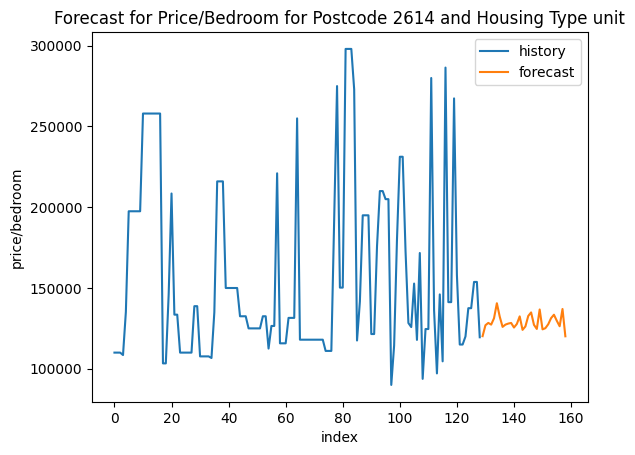

In [215]:
test_model = models_and_postcodes[2614][1]
test_ts = ts_sets[2614][1]
horizon = 30
predict_and_visualize_forecast(test_model, test_ts, horizon)

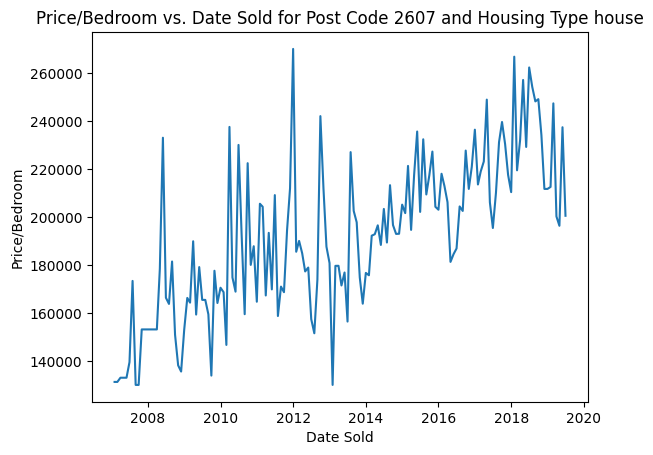

In [150]:
plot_ts(ts_sets[2607][0])

In [138]:
count = 0
for key in models_and_postcodes.keys():
    for model in models_and_postcodes[key]:
        if str(model).split('(')[0] == 'MLForecast':
            count+=1

In [25]:
x = run_NeuralForecast(ts_sets[2607][0], months=20)

Seed set to 22
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | mlp          | ModuleList    | 1.1 M  | train
4 | out          | Linear        | 39.0 K | train
-------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.407     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
Seed set to 22
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | mlp          | ModuleList    | 1.1 M  | train
4 | out          | Linear        | 20.5 K | train
-------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.334     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [30]:
x['y_test_preds']

,ds,MLP
unique_id,,
0,2016-06-01,211866.609375
0,2016-07-01,216960.656250
0,2016-08-01,212068.406250
0,2016-09-01,219235.359375
0,2016-10-01,212744.578125
0,2016-11-01,225637.750000
0,2016-12-01,213727.453125
0,2017-01-01,217415.625000
0,2017-02-01,216306.281250


In [90]:
what = prepare_and_clean_frames(df, 2605, 'unit')

/var/folders/k_/y5wzmsx1483f9z9t9tjtdj1m0000gn/T/ipykernel_50582/3415058516.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  with_inf['price/bedroom'] = np.mean(without_inf['price/bedroom'])


Seed set to 22
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | mlp          | ModuleList    | 1.1 M  | train
4 | out          | Linear        | 39.0 K | train
-------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.407     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(
Seed set to 22
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | mlp          | ModuleList    | 1.1 M  | train
4 | out          | Linear        | 20.5 K | train
-------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.334     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/neuralforecast/core.py:199: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


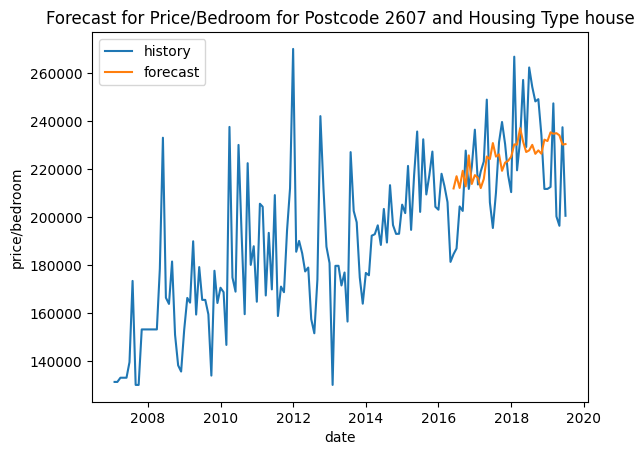

In [33]:
predict_and_visualize_forecast(ts_sets[2607][0], horizon=20)